In [59]:
from glob import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import to_rgba
from tqdm import tqdm

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit

nproc = 4
if nproc > 1:
    from pathos.multiprocessing import ProcessPool as Pool

In [86]:
# create a dictionary mapping corrugation amplitudes to shock aspect ratios
with open ('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_corr1ampl20/joined_vtk/IntSh2-p1.0073.vtk.pkl', 'rb') as f:
    data, _ = pkl.load(f)
    lam = 0.5*(np.max(data['x2v']) - np.min(data['x2v']))
    dx = data['x1v'][1] - data['x1v'][0]
    del data, _
ampl2ar = {}
for suite in ('corrT1_dens', 'corrT2_press'):
    with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/shock_widths.pkl', 'rb') as f:
        amplitudes, widths = pkl.load(f)
    mask = np.where(np.array(widths) > 0)[0]
    amplitudes, ars = np.array(amplitudes)[mask], np.array(widths)[mask]*dx/lam
    ampl2ar[suite] = {ampl:ar for ampl,ar in zip(amplitudes, ars)}
    del amplitudes, widths, mask, ars
    
# create an aspect-ratio colormap for curves
ar_min = np.min(tuple(np.min(tuple(ampl2ar[k].values())) for k in ampl2ar.keys()))
ar_max = np.max(tuple(np.max(tuple(ampl2ar[k].values())) for k in ampl2ar.keys()))
def ar_cmap (ar):
    return cm.rainbow((ar-ar_min)/(ar_max-ar_min))

In [51]:
filenames = sorted(glob('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_corr1ampl20/joined_vtk/*.vtk.pkl'))

with open(filenames[-1], 'rb') as f:
    data = pkl.load(f)[0]

In [52]:
data.keys()

dict_keys(['Time', 'x1f', 'x2f', 'x3f', 'x1v', 'x2v', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3', 'Bcc1', 'Bcc2', 'Bcc3', 'vel_tot', 'gamma', 'Bcc_tot', 'Bcc_fluid_0', 'Bcc_fluid_1', 'Bcc_fluid_2', 'Bcc_fluid_3', 'Bcc_fluid_tot', 'Bcc_fluid_tot_vsZ', 'plasma_beta', 'magnetization', 'enthalpy', 'internal_energy', 'internal_energy_vsZ', 'j_nu', 'j_nu_vsZ', 'alpha_nu', 'alpha_nu_vsZ', 'j_over_alpha_nu', 'j_over_alpha_nu_vsZ', 'flux_density', 'flux_density_vsZ', 'spectrum', 'ddt_internal_energy', 'ddt_internal_energy_vsZ'])

In [53]:
def _vector_orientation (vectors):
    '''Returns orientation phi (Arc tan(y/x)) of the vector field.'''
    result = np.arctan(vectors[...,1] / vectors[...,0])
    result = np.where(
        vectors[...,0] > 0,
        result,
        result - np.pi
    )
    result = np.mod(result, 2.*np.pi)
    return result

# we look at Bfield in counterclockwise manner, shifting by (dx,dy)
# note the margin to ensure periodicity
_phi_angles = tuple(np.arange(-0.75*np.pi, 2.75*np.pi, 0.25*np.pi))
_shifts = (
    (-1,-1), (0,-1), (1,-1),
    (1,0), (1,1), (0,1), (-1,1), (-1,0), (-1,-1), (0,-1), (1,-1),
    (1,0), (1,1), (0,1)
)
def _bfield_angles (bfield, bfield_phi):
    '''For each cell, we limit ourselves to the three neighbours closest to the direction of Bfield in that cell. Then, we report the angles between center cell's Bfield and Bfield at these neighbours.'''
    # calculate which neighbouring cells are closest to where Bfield is pointing
    direction_distances = np.repeat(np.expand_dims(bfield_phi,-1),len(_phi_angles), axis=-1) - _phi_angles
    direction_idxs = np.argpartition(
        np.reshape(np.abs(direction_distances), (-1,len(_phi_angles))),
        3, axis=-1
    )[...,:3]
    direction_idxs = np.reshape(direction_idxs, (*(direction_distances.shape[:-1]),3))
    np.sort(direction_idxs, axis=-1)
    direction_distances = np.take_along_axis(
        direction_distances,
        direction_idxs,
        axis=-1
    )
    # calculate angles between Bfield vectors
    shift_vectors = np.take(
        np.array(_shifts),
        direction_idxs.flatten(),
        axis=0
    )
    shift_vectors = np.reshape(np.array(
        shift_vectors
    ), (*(bfield_phi.shape),3,2))
    shift_vectors = np.transpose(shift_vectors, (-2,-1,0,1))
    indices = np.meshgrid(range(bfield.shape[0]), range(bfield.shape[1]), indexing='ij')
    indices = np.stack(indices)
    indices = np.stack(3*[indices,])[...,1:-1,1:-1]
    rolled_indices = indices + shift_vectors
    bfield_rolled = np.array([
        bfield[i,j] for i,j in rolled_indices
    ])
    bfield_here = np.stack(3*[bfield[...,1:-1,1:-1,:],])
    bfield_angles = np.arccos(
        np.sum(
            bfield_here * bfield_rolled, axis=-1
        ) / np.sqrt(np.sum(bfield_here**2, -1) * np.sum(bfield_rolled**2, -1))
    )
    bfield_angles = np.transpose(np.swapaxes(bfield_angles, 0,-1), (1,0,2))
    
    # clean up and return
    del direction_idxs, shift_vectors, indices, rolled_indices, bfield_rolled, bfield_here
    return direction_distances, bfield_angles
    
def bfield_curvature (data):
    # collect bfields as vectors
    bfield = np.swapaxes(np.array((
        data['Bcc1'],
        data['Bcc2'],
        #data['Bcc3'], # == 0
    )), 0,-1)
    # at each cell, collect angles between the cell's Bfield direction, and Bfield directions in the neighbouring cells
    print('Calculating angles.. ', end='', flush=True)
    bfield_phi = _vector_orientation(bfield)[1:-1,1:-1]
    direction_distance, bfield_angles = _bfield_angles(bfield, bfield_phi)
    print('done.', flush=True)
    # now, interpolate these values as a function of position angle
    # we'll use simple piecewise parabolic interpolation (y = ax2+bx+c)
    print('Interpolating.. ', end='', flush=True)
    x,y = direction_distance, bfield_angles
    a = ( 1./(x[...,2]-x[...,0]) ) * ( (y[...,2]-y[...,1])/(x[...,2]-x[...,1]) - (y[...,1]-y[...,0])/(x[...,1]-x[...,0]) )
    b = (y[...,1]-y[...,0])/(x[...,1]-x[...,0]) - a*(x[...,0]-x[...,1])
    c = y[...,0] - a*x[...,0]**2 - b*x[...,0]
    bfield_rotation = c
    del bfield, direction_distance, bfield_angles, x,y, a,b
    print('Done.', flush=True)
    print('Calculating curvature radius.. ', end='', flush=True)
    # we also need a length scale, we take it from the square-neighbourhood of our bfield
    vectors = np.stack((
        np.cos(bfield_phi), np.sin(bfield_phi)
    ))
    # normalize so that one coordinate ==1 (i.e., we're on a unit square)
    vectors /= np.where(
        vectors[0] > vectors[1],
        vectors[0],
        vectors[1]
    )
    length = np.sqrt(np.sum(
        vectors**2, axis=0
    ))
    del vectors
    # calculate curvature radius
    curvature = bfield_rotation / length
    print('done.', flush=True)
    
    # clean up and return
    del bfield_phi, c, length 
    return np.transpose(curvature)

In [5]:
curvature = bfield_curvature(data)

Calculating angles.. 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arctan
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in remainder
  if __name__ == '__main__':


done.
Interpolating.. 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in arccos


Done.
Calculating curvature radius.. done.


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in greater


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


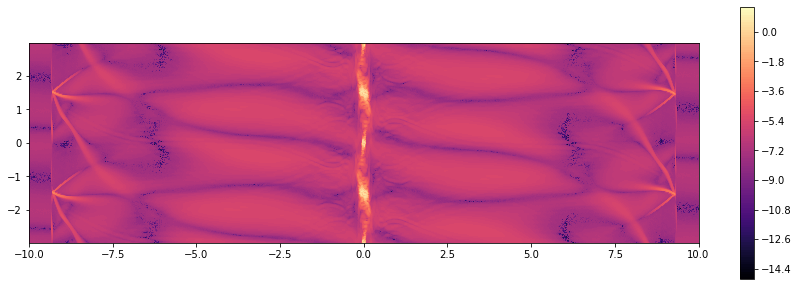

In [6]:
if False:
    curvature_to_plot = gaussian_filter(
        np.where(
            curvature > np.exp(-15),
            np.log(curvature), -15
        ), 1, mode='wrap'
    )
else:
    curvature_to_plot = np.where(
        curvature > np.exp(-15),
        np.log(curvature), -15
    )

plt.figure(figsize=(15,5))
plt.contourf(
    data['x1v'][1:-1], data['x2v'][1:-1],
    curvature_to_plot,
    128,
    cmap='magma')
plt.xlim(-10,10)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show(); plt.close()

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


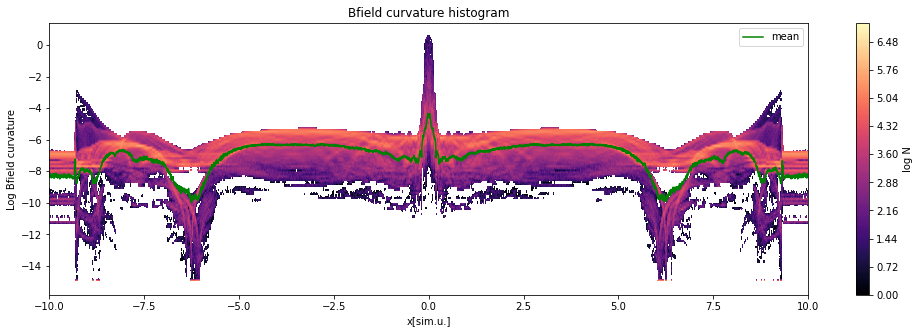

In [7]:
bins = np.linspace(np.min(curvature_to_plot),np.max(curvature_to_plot), 128)
hist = np.transpose([np.histogram(row, bins=bins)[0] for row in np.transpose(curvature_to_plot)])

plt.figure(figsize=(17,5))
plt.contourf(data['x1v'][1:-1], 0.5*(bins[1:]+bins[:-1]), np.log(hist), 128, cmap='magma')
plt.colorbar(label='log N')
plt.ylabel('Log N')
plt.xlabel('x[sim.u.]')
plt.ylabel('Log Bfield curvature')
plt.title('Bfield curvature histogram')
plt.xlim(-10,10)

plt.plot(
    data['x1v'][1:-1],
    np.mean(curvature_to_plot, axis=0),
    color='green',
    label='mean'
)
plt.legend()

plt.show(); plt.close()

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


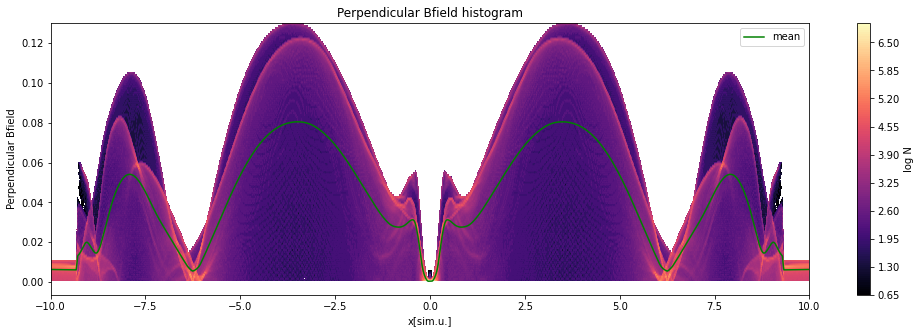

In [8]:
bins = np.linspace(0.,np.max(np.abs(data['Bcc1'])), 128)
hist = np.transpose([np.histogram(np.abs(row), bins=bins)[0] for row in np.transpose(data['Bcc1'])])

plt.figure(figsize=(17,5))
plt.contourf(data['x1v'], 0.5*(bins[1:]+bins[:-1]), np.log(hist), 128, cmap='magma')
plt.colorbar(label='log N')
plt.xlabel('x[sim.u.]')
plt.ylabel('Perpendicular Bfield')
plt.title('Perpendicular Bfield histogram')
plt.xlim(-10,10)

plt.plot(
    data['x1v'],
    np.mean(np.abs(data['Bcc1']), axis=0),
    label='mean', color='green'
)
plt.legend()

plt.show(); plt.close()

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


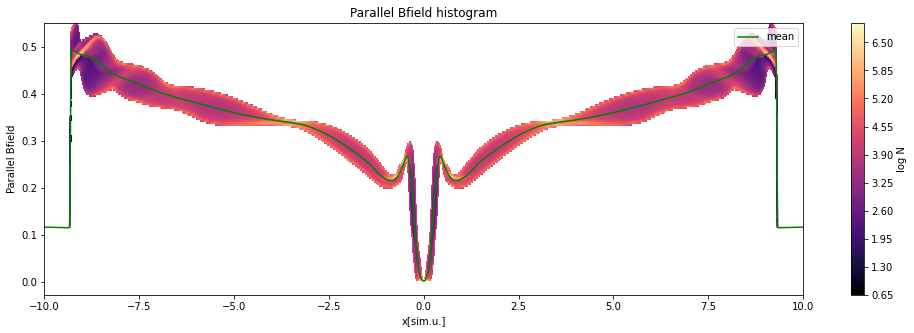

In [9]:
bins = np.linspace(0.,np.max(np.abs(data['Bcc2'])), 128)
hist = np.transpose([np.histogram(np.abs(row), bins=bins)[0] for row in np.transpose(data['Bcc2'])])

plt.figure(figsize=(17,5))
plt.contourf(data['x1v'], 0.5*(bins[1:]+bins[:-1]), np.log(hist), 128, cmap='magma')
plt.colorbar(label='log N')
plt.xlabel('x[sim.u.]')
plt.ylabel('Parallel Bfield')
plt.title('Parallel Bfield histogram')
plt.xlim(-10,10)

plt.plot(
    data['x1v'],
    np.mean(np.abs(data['Bcc2']), axis=0),
    label='mean', color='green'
)
plt.legend()

plt.show(); plt.close()

In [10]:
# maximum sensible curvature
dx = data['x1v'][1] - data['x1v'][0]
dy = data['x2v'][1] - data['x2v'][0]
cmax = 1.0 / min(dx,dy)
print(f'Maximum sensible curvature is log({cmax:.2f}) = {np.log(cmax):.2f}.')

Maximum sensible curvature is log(204.80) = 5.32.


---
### Parallel Bfield decay slope

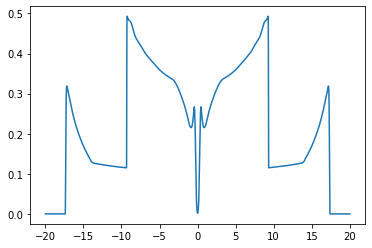

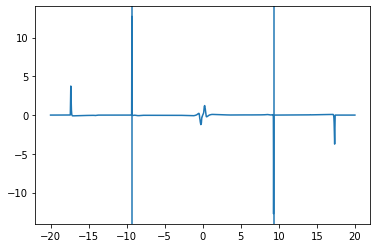

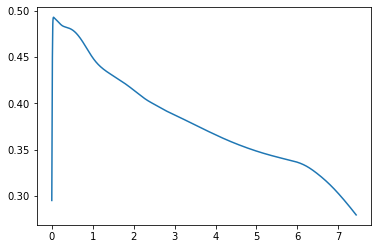

In [11]:
# 1. find the shocks

filename = sorted(glob('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_corr1ampl20/joined_vtk/*.vtk.pkl'))[-1]
with open(filename, 'rb') as f:
    data = pkl.load(f)[0]

x = data['x1v']
y = np.mean(np.abs(data['Bcc2']), axis=0)
plt.plot(x,y)
plt.show(); plt.close()

xavg = 0.5*(x[1:]+x[:-1])
dx = x[1:]-x[:-1]
dy = y[1:]-y[:-1]
plt.plot(xavg, dy/dx)

ish = np.argmax(dy/dx), np.argmax(-dy/dx)
xsh = xavg[ish[0]], xavg[ish[1]]
plt.axvline(xsh[0])
plt.axvline(xsh[1])

plt.show(); plt.close()

# 2. collect the data, show as distance from the shock

mid = np.int(len(x) / 2)
left = y[ish[0]:mid]
right = y[ish[1]:mid:-1]
ll = np.int(0.8*min(len(left), len(right)))
y = 0.5*(left[:ll] + right[:ll])
x = np.arange(ll)*dx[0]

plt.plot(x,y)
plt.show(); plt.close()

In [12]:
def broken_pl (x, xbr, p1, p2, A):
    return A / ( (xbr/x)**p1 + (xbr/x)**p2 )
#A * (x/xbr)**np.where(x < xbr, p1,p2)

  0%|          | 0/6 [00:00<?, ?it/s]/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
 17%|█▋        | 1/6 [00:01<00:05,  1.16s/it]/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
 33%|███▎      | 2/6 [00:02<00:04,  1.20s/it]/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
 50%|█████     

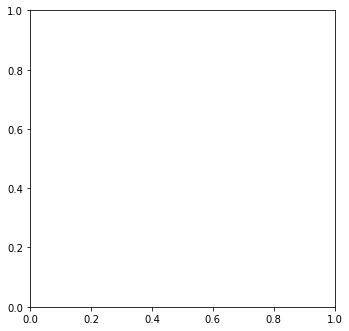

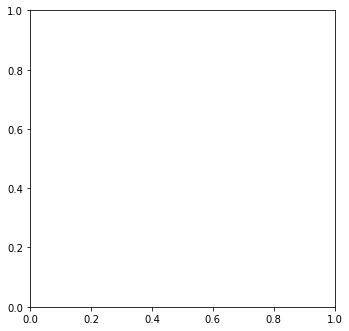

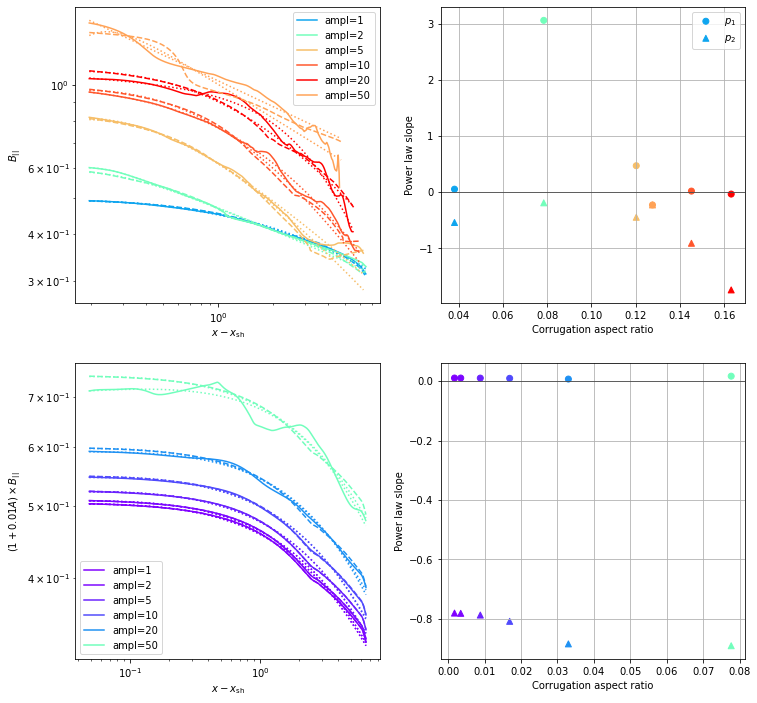

In [87]:
linestyles = {0:'--', 1:'-'}
amplitudes = (1,2,5,10,20,50,75,100)[:-2]
datasets = ('corrT1_dens', 'corrT2_press')
cmap = plt.get_cmap('gist_rainbow')

shock_width = {'corrT1_dens':0.2, 'corrT2_press':0.05} # in distance
end_break = {'corrT1_dens':0.7, 'corrT2_press':0.7} # in distance

plt.figure(figsize=(12,12))

for i,dataset in enumerate(datasets):
    slopes = []
    plt.subplot(2,2,2*i+1)
    for ampl in tqdm(amplitudes):
        if ampl not in ampl2ar[dataset].keys(): continue
        multiplier = (1+0.01*ampl) if dataset == 'corrT2_press' else 1.0
        for corr in (0,1):
            filename = sorted(glob(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{dataset}/prod1_corr_ampl/results_corr{corr}ampl{ampl}/joined_vtk/*.vtk.pkl'))[-1]
            with open(filename, 'rb') as f:
                data = pkl.load(f)[0]

            x = data['x1v']
            y = np.mean(np.abs(data['Bcc2']), axis=0)

            xavg = 0.5*(x[1:]+x[:-1])
            dx = x[1:]-x[:-1]
            dy = y[1:]-y[:-1]

            ish = np.argmax(dy/dx), np.argmax(-dy/dx)

            if False:
                plt.plot(x,y)
                xsh = xavg[ish[0]], xavg[ish[1]]
                plt.axvline(xsh[0], color='k')
                plt.axvline(xsh[1], color='k')
                plt.show(); plt.close()

            # 2. collect the data, show as distance from the shock

            mid = np.int(len(x) / 2)
            left = y[ish[0]:mid]
            right = y[ish[1]:mid:-1]
            ll = np.int(end_break[dataset]*min(len(left), len(right)))
            start = np.int(shock_width[dataset] / dx[0])
            y = 0.5*(left[start:ll] + right[start:ll])
            x = np.arange(ll)[start:]*dx[0]

            # fit a broken power law
            pars, cov = curve_fit(
                broken_pl, x, y,
                p0=(1.0, 0, -1, 0.5),
                #bounds=((0.,0.,-1,-np.inf),(0.1,5.,1,np.inf)),
                sigma=x
            )
            errors = np.sqrt(np.diag(cov))

            # clean up
            del xavg, dx, dy, ish, mid, left, right, ll
            
            #color = cmap((np.log(ampl)-np.log(np.min(amplitudes)))/(np.log(np.max(amplitudes))-np.log(np.min(amplitudes))))
            color = ar_cmap(ampl2ar[dataset][ampl])
            kwargs = dict(
                linestyle=linestyles[corr],
                color=color
            )
            if corr == 1:
                kwargs['label'] = f'ampl={ampl}'
            plt.plot(
                x,y * multiplier, **kwargs
            )

    #         plt.scatter(
    #             x,y,
    #             color=cm.rainbow((ampl-np.min(amplitudes))/(np.max(amplitudes)-np.min(amplitudes)))
    #         )

            # overplot the fit
            plt.plot(
                x,
                broken_pl(x, *pars) * multiplier,
                linestyle=':',
                color=color
            )

            # save the fit for later plotting
            if corr == 1:
                slopes.append(
                    [ampl, *pars, *errors, *color]
                )
                
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.xlabel('$x-x_{\\rm sh}$')
    plt.ylabel('$B_{||}$' if dataset == 'corrT1_dens' else '$(1+0.01A) \\times B_{||}$')
    plt.legend()
    
    # plot the slopes
    slopes = np.array(slopes).T
    colors = slopes[-4:].T
    plt.subplot(2,2,2*i+2)
    ars = [ampl2ar[dataset][x] if x in ampl2ar[dataset].keys() else None for x in slopes[0]]
    if True:
        plt.scatter(ars, slopes[2], label='$p_1$', c=colors, marker='o')
        plt.scatter(ars, slopes[3], label='$p_2$', c=colors, marker='^')
    else:
        for ii in range(len(ars)):
            plt.errorbar(ars[ii], slopes[2,ii], yerr=slopes[7,ii], label='$p_1$', c=colors[ii], marker='o')
            plt.errorbar(ars[ii], slopes[3,ii], yerr=slopes[8,ii], label='$p_2$', c=colors[ii], marker='^')
    if i == 0: plt.legend()
    plt.xlabel('Corrugation aspect ratio')
    plt.ylabel('Power law slope')
    plt.grid()
    plt.axhline(0., color='k', linewidth=0.5)
    
plt.show(); plt.close()

In [ ]:
par_name = {0:'xbr', 1:'p1', 2:'p2', 3:'xcut', 4:'A'}

plt.figure(figsize=(12,12))
npars = slopes.shape[0]-1
for i in range(npars):
    plt.subplot(3,2,i+1)
    plt.scatter(slopes[0], slopes[i+1])
    plt.title(par_name[i])
plt.tight_layout()
plt.show()
plt.close()